## Data Gaps in Flair
This notebook is to investigate gap durations in flair dataset.


In [1]:
from matplotlib import pyplot as plt
import pandas as pd

import sys
import os
file_dir = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(file_dir,'..'))

from src import tdd
from datetime import datetime, timedelta
from studies.flair import Flair

In [ ]:
flair = Flair(os.path.join(file_dir,'..','data','raw','FLAIRPublicDataSet'))
flair.load_data()
df_basal = flair.extract_basal_event_history()
df_bolus = flair.extract_bolus_event_history()
df_cgm = flair.extract_cgm_history()

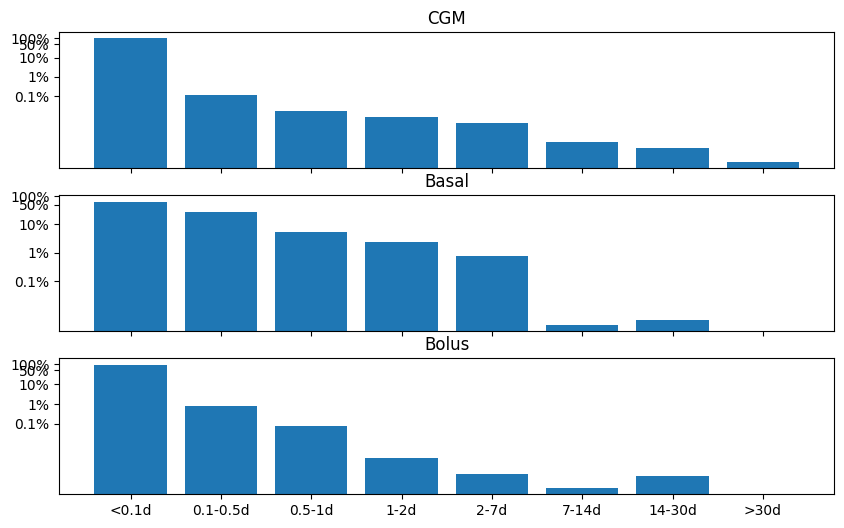

In [67]:
import numpy as np
def drawHourlyGaps(gaps,ax):
    count,range = np.histogram(gaps.dropna()/24, bins=[0,0.1,0.5,1,2,7,14,30,np.inf])
    ax.bar(np.arange(len(count)),count/np.sum(count)); ax.set_yscale('log')
    ax.set_yticks([0.001,0.01,0.1,0.5,1]);
    ax.set_yticklabels(['0.1%','1%','10%','50%','100%'])
    ax.set_xticks(np.arange(len(count)),['<0.1d','0.1-0.5d','0.5-1d','1-2d','2-7d','7-14d','14-30d','>30d'])
    
gaps_cgm = df_cgm.sort_values(by='datetime').groupby('patient_id').datetime.apply('diff').dt.total_seconds()/(3600)
gaps_basal = df_basal.sort_values(by='datetime').groupby('patient_id').datetime.apply('diff').dt.total_seconds()/(3600)
gaps_bolus = df_bolus.sort_values(by='datetime').groupby('patient_id').datetime.apply('diff').dt.total_seconds()/(3600)

f,AX = plt.subplots(3,1,figsize=(10,6),sharex=True)
AX[0].set_title('CGM')
drawHourlyGaps(gaps_cgm, AX[0])
AX[1].set_title('Basal')
drawHourlyGaps(gaps_basal, AX[1])
AX[2].set_title('Bolus')
drawHourlyGaps(gaps_bolus,AX[2])


In [72]:
flair.df_pump.groupby('PtID').DateTime.agg(lambda x: x.diff().dt.total_seconds().max()/3600).sort_values()

PtID
89       1.000000
101      2.556389
62       2.581111
39       2.593889
21       2.606111
          ...    
4      335.603333
7      360.000278
29     378.306667
38     411.864722
98     531.200833
Name: DateTime, Length: 115, dtype: float64

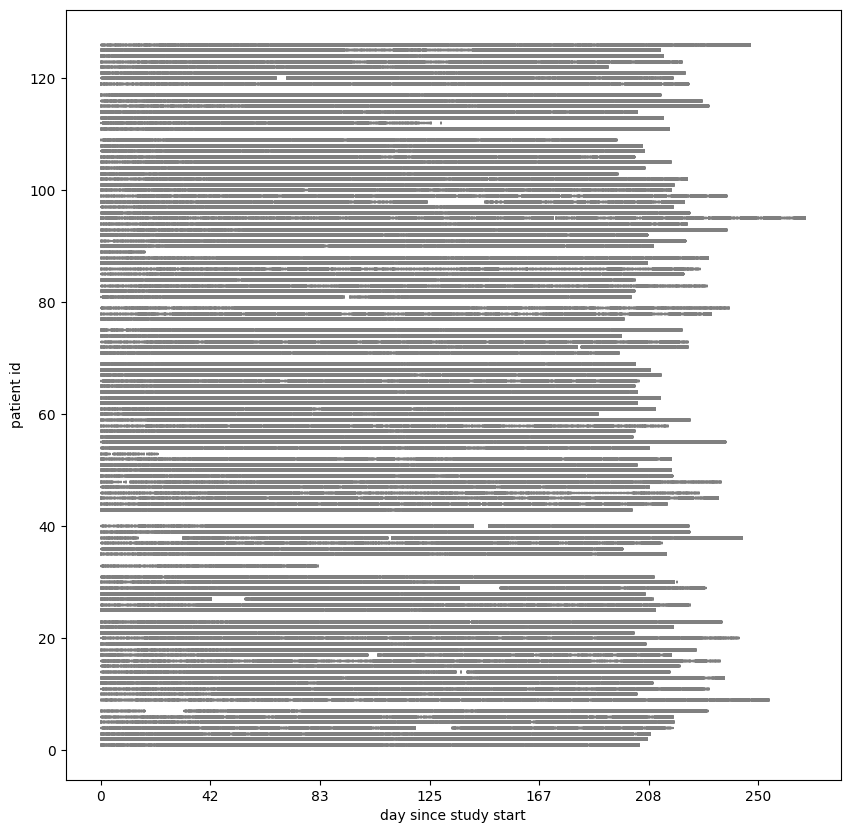

In [128]:
import drawing
#reload drawing module
from importlib import reload
reload(drawing)

plt.figure(figsize=(10,10)); ax = plt.gca()
for patient_id in np.sort(flair.df_pump.PtID.unique()):
    tmp = flair.df_pump.loc[flair.df_pump.PtID==patient_id]
    time_since_study_start = (tmp.DateTime-tmp.DateTime.min()).apply(lambda x: x.total_seconds()/3600)
    #time_since_study_start = (tmp.DateTime-tmp.DateTime.min())/(tmp.DateTime.max()-tmp.DateTime.min())
    ax.scatter(time_since_study_start, np.ones(tmp.shape[0])*patient_id, marker='_',s=1,label='pump',color='gray')

    #tmp = flair.df_cgm.loc[flair.df_cgm.PtID==98]
    #plt.scatter(tmp.DateTime, np.ones(tmp.shape[0])*0.5, 0.5, alpha=0.5, marker='.',color='gray',label='cgm')
    #plt.legend()
    #plt.ylim(0,1.5)
    #plt.yticks([]);
ax.set_xlabel('day since study start')
ax.set_ylabel('patient id')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/24:.0f}'))